In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

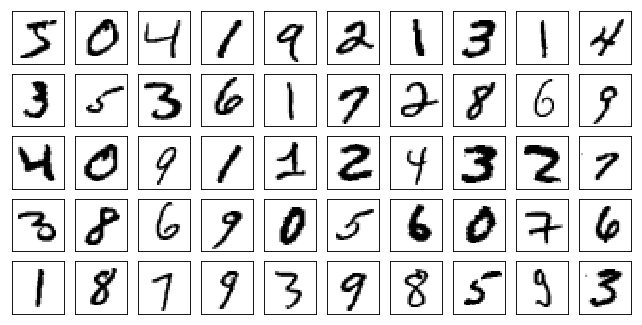

In [5]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)    
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [7]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [8]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [9]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [19]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [20]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.327425 1: 2.340549 2: 2.296613 3: 2.290284
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.528703 1: 0.646311 2: 0.522253 3: 0.682473
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.300755 1: 0.297055 2: 0.292518 3: 0.301515
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.491225 1: 0.382450 2: 0.479021 3: 0.388505
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.388524 1: 0.344619 2: 0.382316 3: 0.344652
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.210931 1: 0.185536 2: 0.231152 3: 0.204111
Test set:
0: Loss: 0.2578	Accuracy: 9232/10000 (92%)
1: Loss: 0.1998	Accuracy: 9418/10000 (94%)
2: Loss: 0.2527	Accuracy: 9243/10000 (92%)
3: Loss: 0.2102	Accuracy: 9383/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.446509 1: 0.342857 2: 0.428970 3: 0.378852
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.185910 1: 0.140166 2: 0.172756 3: 0.162060
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.229983 1: 0.189725 2: 0.207024 3: 0.226461
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.075219 1: 0.045865 2: 0.056565 3: 0.055696
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.082602 1: 0.057633 2: 0.064620 3: 0.040889
Test set:
0: Loss: 0.0919	Accuracy: 9732/10000 (97%)
1: Loss: 0.0803	Accuracy: 9795/10000 (97%)
2: Loss: 0.0849	Accuracy: 9761/10000 (97%)
3: Loss: 0.0788	Accuracy: 9784/10000 (97%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.049020 1: 0.014964 2: 0.047294 3: 0.018037
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.042093 1: 0.008380 2: 0.030662 3: 0.009727
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.012305 1: 0.002360 2: 0.006216 3: 0.011906
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.069471 1: 0.018460 2: 0.056218 3: 0.009554
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.011594 1: 0.068560 2: 0.008868 3: 0.022940
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.006807 1: 0.000464 2: 0.002929 3: 0.001421
Test set:
0: Loss: 0.0870	Accuracy: 9753/10000 (97%)
1: Loss: 0.0856	Accuracy: 9779/10000 (9

In [21]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

In [22]:
torch.save(models[3], './model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Вывод результатов

In [10]:
model = torch.load('./model_classifier')

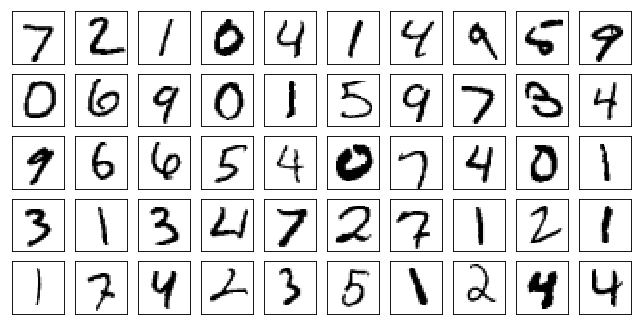

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [11]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

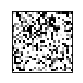

In [15]:
data, _ = next(iter(test_loader))
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [16]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)       
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    
    loss_stats = []    
    lr=1e-1

    for i in range(1, 1000001):  
                
        out = model.forward(gen_img_par)      
                 
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)    
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target) 
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-7:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1


        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par, loss_stats      


In [ ]:
new_image_randn = generate_image(img, 4)

Iteration 5000: loss=0.0 prediction=4 lr=0.1
Iteration 10000: loss=0.0 prediction=4 lr=0.1
Iteration 15000: loss=0.0 prediction=4 lr=0.1
